<a href="https://colab.research.google.com/github/petyaslavkova/Bachelorarbeit/blob/main/RealFaceToSimpsonsBachelor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Colab's file access feature
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


#Install CycleGAN

In [3]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2337, done.
remote: Total 2337 (delta 0), reused 0 (delta 0), pack-reused 2337
Receiving objects: 100% (2337/2337), 8.09 MiB | 1.19 MiB/s, done.
Resolving deltas: 100% (1499/1499), done.


In [4]:
import os
os.chdir('pytorch-CycleGAN-and-pix2pix/')

In [5]:

!pip install -r requirements.txt

     |████████████████████████████████| 686kB 14.0MB/s 
     |████████████████████████████████| 61kB 8.8MB/s 
  Created wheel for visdom: filename=visdom-0.1.8.9-cp37-none-any.whl size=655251 sha256=9279b43b691ebab49804034a3e7d6d6a2d928039f252323406dba02bf6fa6682
  Stored in directory: /root/.cache/pip/wheels/70/19/a7/6d589ed967f4dfefd33bc166d081257bd4ed0cb618dccfd62a
  Created wheel for torchfile: filename=torchfile-0.1.0-cp37-none-any.whl size=5713 sha256=a724d8cf17fb98af5eaf755cb31a66a0a86f097c60a2cf67f840008815188c9e
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built visdom torchfile


#Datasets implementierung

In [6]:

LIMIT = 10000
one_epoch = ((LIMIT/100) * 50)/60 
EPOCHS = 10
print(f'{EPOCHS} epochs would take {one_epoch*EPOCHS/60} hours')

10 epochs would take 13.888888888888888 hours


In [7]:
from pathlib import Path
from fastai import *
import glob
from fastai.vision import *

TRAIN_A_NAME = 'simpsons_faces'
TRAIN_B_NAME = 'human_face'
DATASET = Path('/content/pytorch-CycleGAN-and-pix2pix/datasets/'+TRAIN_A_NAME)
TRAIN_A = Path('/content/pytorch-CycleGAN-and-pix2pix/datasets/'+TRAIN_A_NAME+'/trainA')
TRAIN_B = Path('/content/pytorch-CycleGAN-and-pix2pix/datasets/'+TRAIN_A_NAME+'/trainB')
TEST_A = Path('/content/pytorch-CycleGAN-and-pix2pix/datasets/'+TRAIN_A_NAME+'/testA')
TEST_B = Path('/content/pytorch-CycleGAN-and-pix2pix/datasets/'+TRAIN_A_NAME+'/testB')
URLS_FILE = 'urls.txt'

!rm -Rf $DATASET
os.makedirs(DATASET, exist_ok = True)
os.makedirs(TRAIN_A, exist_ok = True)
os.makedirs(TRAIN_B, exist_ok = True)
os.makedirs(TEST_A, exist_ok = True)
os.makedirs(TEST_B, exist_ok = True)

#Simpsons Faceset

In [8]:
def create_training_dataset_simpson_faces(download_dir):

  %cd $download_dir

  # download dataset and unzip
  !kaggle datasets download kostastokis/simpsons-faces --force
  !unzip \*.zip
  !rm *.zip
  !cp -a $download_dir/cropped/. $download_dir

  # remove unnecessary folders
  !rm -Rf $download_dir/cropped
  !rm -Rf $download_dir/simplified

  # go back to orig directory
  %cd /content/pytorch-CycleGAN-and-pix2pix

create_training_dataset_simpson_faces(TRAIN_A)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: simplified/539.png      
  inflating: simplified/5390.png     
  inflating: simplified/5391.png     
  inflating: simplified/5392.png     
  inflating: simplified/5393.png     
  inflating: simplified/5394.png     
  inflating: simplified/5395.png     
  inflating: simplified/5396.png     
  inflating: simplified/5397.png     
  inflating: simplified/5398.png     
  inflating: simplified/5399.png     
  inflating: simplified/54.png       
  inflating: simplified/540.png      
  inflating: simplified/5400.png     
  inflating: simplified/5401.png     
  inflating: simplified/5402.png     
  inflating: simplified/5403.png     
  inflating: simplified/5404.png     
  inflating: simplified/5405.png     
  inflating: simplified/5406.png     
  inflating: simplified/5407.png     
  inflating: simplified/5408.png     
  inflating: simplified/5409.png     
  inflating: simplified/541.png      
  inflating: simplifi

#Real Faceset implementieren und mit StyleGAN Real Faces erstellen

In [9]:
#StyleGAN installation
%cd /content/

%tensorflow_version 1.x
import tensorflow as tf

# Download the code
#!git clone https://github.com/NVlabs/stylegan2.git
!git clone https://github.com/spiyer99/stylegan2
# !pip install tf-nightly-gpu
%cd stylegan2
!nvcc test_nvcc.cu -o test_nvcc -run
!nvidia-smi -L

/content
TensorFlow 1.x selected.
Cloning into 'stylegan2'...
remote: Enumerating objects: 109, done.
remote: Total 109 (delta 0), reused 0 (delta 0), pack-reused 109
Receiving objects: 100% (109/109), 586.72 KiB | 1.44 MiB/s, done.
Resolving deltas: 100% (43/43), done.
/content/stylegan2
CPU says hello.
GPU says hello.
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-7aa72af2-8da1-6892-8fdd-6d5f20dff947)


In [10]:
# Download the model of choice
%cd /content/stylegan2/
import argparse
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import re
import sys
from io import BytesIO
import IPython.display
import numpy as np
from math import ceil
from PIL import Image, ImageDraw
import imageio

import pretrained_networks

# Choose between these pretrained models - I think 'f' is the best choice:

# 1024×1024 faces
# stylegan2-ffhq-config-a.pkl
# stylegan2-ffhq-config-b.pkl
# stylegan2-ffhq-config-c.pkl
# stylegan2-ffhq-config-d.pkl
# stylegan2-ffhq-config-e.pkl
# stylegan2-ffhq-config-f.pkl

# 512×384 cars
# stylegan2-car-config-a.pkl
# stylegan2-car-config-b.pkl
# stylegan2-car-config-c.pkl
# stylegan2-car-config-d.pkl
# stylegan2-car-config-e.pkl
# stylegan2-car-config-f.pkl

# 256x256 horses
# stylegan2-horse-config-a.pkl
# stylegan2-horse-config-f.pkl

# 256x256 churches
# stylegan2-church-config-a.pkl
# stylegan2-church-config-f.pkl

# 256x256 cats
# stylegan2-cat-config-f.pkl
# stylegan2-cat-config-a.pkl
network_pkl = "gdrive:networks/stylegan2-ffhq-config-f.pkl"

# If downloads fails, due to 'Google Drive download quota exceeded' you can try downloading manually from your own Google Drive account
# network_pkl = "/content/drive/My Drive/GAN/stylegan2-ffhq-config-f.pkl"

print('Loading networks from "%s"...' % network_pkl)
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

/content/stylegan2
Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


In [11]:
# Useful utility functions...

# Generates a list of images, based on a list of latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_in_w_space(dlatents, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    Gs_kwargs.truncation_psi = truncation_psi
    dlatent_avg = Gs.get_var('dlatent_avg') # [component]

    imgs = []
    for row, dlatent in log_progress(enumerate(dlatents), name = "Generating images"):
        #row_dlatents = (dlatent[np.newaxis] - dlatent_avg) * np.reshape(truncation_psi, [-1, 1, 1]) + dlatent_avg
        dl = (dlatent-dlatent_avg)*truncation_psi   + dlatent_avg
        row_images = Gs.components.synthesis.run(dlatent,  **Gs_kwargs)
        imgs.append(PIL.Image.fromarray(row_images[0], 'RGB'))
    return imgs       

def generate_images(zs, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    imgs = []
    for z_idx, z in log_progress(enumerate(zs), size = len(zs), name = "Generating images"):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
        imgs.append(PIL.Image.fromarray(images[0], 'RGB'))
    return imgs

def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

# Generates a list of images, based on a list of seed for latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_zs_from_seeds(seeds), truncation_psi)

def saveImgs(imgs, location):
  for idx, img in log_progress(enumerate(imgs), size = len(imgs), name="Saving images"):
    file = location+ str(idx) + ".png"
    img.save(file)

def imshow(a, format='png', jpeg_fallback=True):
  a = np.asarray(a, dtype=np.uint8)
  str_file = BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

        
def clamp(x, minimum, maximum):
    return max(minimum, min(x, maximum))
    
def drawLatent(image,latents,x,y,x2,y2, color=(255,0,0,100)):
  buffer = PIL.Image.new('RGBA', image.size, (0,0,0,0))
   
  draw = ImageDraw.Draw(buffer)
  cy = (y+y2)/2
  draw.rectangle([x,y,x2,y2],fill=(255,255,255,180), outline=(0,0,0,180))
  for i in range(len(latents)):
    mx = x + (x2-x)*(float(i)/len(latents))
    h = (y2-y)*latents[i]*0.1
    h = clamp(h,cy-y2,y2-cy)
    draw.line((mx,cy,mx,cy+h),fill=color)
  return PIL.Image.alpha_composite(image,buffer)
             
  
def createImageGrid(images, scale=0.25, rows=1):
   w,h = images[0].size
   w = int(w*scale)
   h = int(h*scale)
   height = rows*h
   cols = ceil(len(images) / rows)
   width = cols*w
   canvas = PIL.Image.new('RGBA', (width,height), 'white')
   for i,img in enumerate(images):
     img = img.resize((w,h), PIL.Image.ANTIALIAS)
     canvas.paste(img, (w*(i % cols), h*(i // cols))) 
   return canvas

def convertZtoW(latent, truncation_psi=0.7, truncation_cutoff=9):
  dlatent = Gs.components.mapping.run(latent, None) # [seed, layer, component]
  dlatent_avg = Gs.get_var('dlatent_avg') # [component]
  for i in range(truncation_cutoff):
    dlatent[0][i] = (dlatent[0][i]-dlatent_avg)*truncation_psi + dlatent_avg
    
  return dlatent

def interpolate(zs, steps):
   out = []
   for i in range(len(zs)-1):
    for index in range(steps):
     fraction = index/float(steps) 
     out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
   return out

# Taken from https://github.com/alexanderkuk/log-progress
def log_progress(sequence, every=1, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )


In [12]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

def create_training_dataset_real_faces_stylegan(download_dir):

  # create in batches of 100
  # reduces RAM requirements

  counter = 0
  pbar = tqdm(total = LIMIT)

  while counter < LIMIT:

    seeds = np.random.randint(10000000, size=100)
    imgs = generate_images_from_seeds(seeds, 0.7)

    for img in imgs:
      img.save(download_dir/'real_face_{}.jpg'.format(counter), 'JPEG', quality=100)
      counter+=1
      pbar.update(1)
    del imgs

create_training_dataset_real_faces_stylegan(TRAIN_B)

#Train Test Split

In [13]:
# move images to a new folder
# `images` is the existing image directory: 
# `new_dir` is the path that the images will be moved to
# `files_limit` is the limit of files that will be moved
def move_all_images_to_new_folder(images, new_dir, files_limit = None):
  files = glob.glob(str(images/'*.*g'))

  if(files_limit is not None):
    files = files[:files_limit]

  for file in files: shutil.move(file, new_dir/os.path.basename(file))

move_all_images_to_new_folder(TRAIN_A, new_dir = TEST_A, files_limit = int(min(LIMIT*0.1, 25)))
move_all_images_to_new_folder(TRAIN_B, new_dir = TEST_B, files_limit = int(min(LIMIT*0.1, 25)))

9852 imgs in TRAIN_A directory


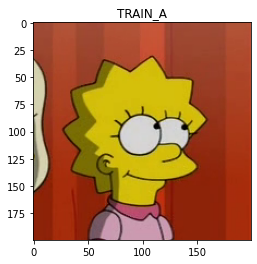

9975 imgs in TRAIN_B directory


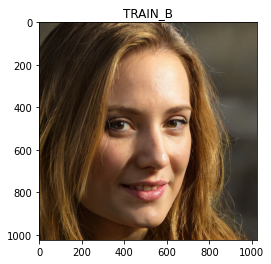

25 imgs in TEST_A directory


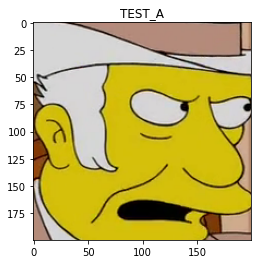

25 imgs in TEST_B directory


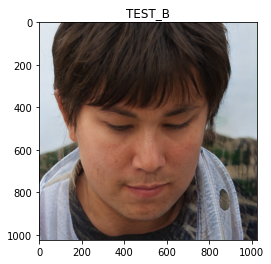

In [14]:
import PIL
import random

def plot_from_image_path(path, title):

  all_imgs = glob.glob(str(path/'*.*g'))

  print(f'{len(all_imgs)} imgs in {title} directory')

  img_path = random.choice(all_imgs)
  img = PIL.Image.open(img_path)
  plt.imshow(img)
  plt.title(title)
  plt.show()

plot_from_image_path(TRAIN_A, 'TRAIN_A')
plot_from_image_path(TRAIN_B, 'TRAIN_B')

plot_from_image_path(TEST_A, 'TEST_A')
plot_from_image_path(TEST_B, 'TEST_B')

# Training Model Real Faces to Simpsons

In [24]:
%cd /content/pytorch-CycleGAN-and-pix2pix

/content/pytorch-CycleGAN-and-pix2pix


In [16]:
import gc; gc.collect()
NAME = 'person2simpson'
BATCH_SIZE = 2

In [17]:
import pdb

In [18]:
import os
from pathlib import Path
from distutils.dir_util import copy_tree
import matplotlib.pyplot as plt
import random

def copy_to_drive(folder = 'cyclegan_simpsonify'):

  drive_folder = Path('/content/drive/My Drive/')/folder

  if(drive_folder.exists()):
    shutil.rmtree(drive_folder)

  shutil.copytree('/content/pytorch-CycleGAN-and-pix2pix/checkpoints/'+NAME+'/', str(drive_folder))

def get_corresponding_photo(file_path):
  return file_path.replace('fake', 'real')

def plot_results(number):

  for i in range(number):

    img_path = random.choice(glob.glob('./results/'+NAME+'/test_latest/images/*fake.*g'))
    print(img_path)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title('fake')
    plt.show()

    print(get_corresponding_photo(img_path))
    img = plt.imread(get_corresponding_photo(img_path))
    plt.imshow(img)
    plt.title('real')
    plt.show()

def get_model(src, dst):

  # copy across model
  try:
    os.remove(dst)
  except:
    pass
  shutil.copyfile(src, dst)

def copy_from_drive(folder = 'cyclegan_simpsonify'):

  drive_folder = Path('/content/drive/My Drive/')/folder

  if(not Path('/content/pytorch-CycleGAN-and-pix2pix/checkpoints/').exists()): 
    os.mkdir('/content/pytorch-CycleGAN-and-pix2pix/checkpoints/')

  if(Path('/content/pytorch-CycleGAN-and-pix2pix/checkpoints/'+NAME+'/').exists()): 
    shutil.rmtree('/content/pytorch-CycleGAN-and-pix2pix/checkpoints/'+NAME+'/')

  shutil.copytree(str(drive_folder), '/content/pytorch-CycleGAN-and-pix2pix/checkpoints/'+NAME+'/')

def test_model (number_results = 5, direction = 'BtoA', src = None, dst = None):
   
 
  
  # delete results folder and recrete
  shutil.rmtree('./results')
  os.mkdir('./results')

  # get appropriate model
  if (src is None): src = './checkpoints/'+NAME+'/latest_net_G_'+direction.split('to')[-1]+'.pth'
  if (dst is None): dst = './checkpoints/'+NAME+'/latest_net_G.pth'

  get_model(src, dst)

  if (direction == 'BtoA'):
    test = TEST_B
  else:
    test = TEST_A
  
  cmd = 'python test.py --dataroot '+str(test)+' --name '+str(NAME)+' --model test --no_dropout'
  os.system(cmd)
  plot_results(number_results)

In [19]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 160690 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.26-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.26-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.26-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import time
from options.train_options import TrainOptions
from data import create_dataset
from models import create_model
from util.visualizer import Visualizer
import shutil
import os
from pathlib import Path
from tqdm.notebook import tqdm


opt = TrainOptions()  # TODO: TrainOptions().parse(**args) not working. Look into this.
opt.name = NAME
opt.dataroot = TRAIN_A.parent
opt.batch_size=BATCH_SIZE
opt.beta1=0.5
opt.checkpoints_dir='./checkpoints'
opt.continue_train=False
opt.crop_size=256
opt.dataset_mode='unaligned'
opt.direction='BtoA'
opt.display_env='main'
opt.display_freq=400
opt.display_id=1
opt.display_ncols=4
opt.display_port=8097
opt.display_server='http://localhost'
opt.display_winsize=256
opt.epoch='latest'
opt.epoch_count=1
opt.gan_mode='lsgan'
opt.gpu_ids=[0]
opt.init_gain=0.02
opt.init_type='normal'
opt.input_nc=3
opt.isTrain=True
opt.lambda_A=10.0
opt.lambda_B=10.0
opt.lambda_identity=0.5
opt.load_iter=0
opt.load_size=286
opt.lr=2e-4
opt.lr_decay_iters=50
opt.lr_policy='linear'
opt.max_dataset_size=float("inf")
opt.n_epochs=EPOCHS
opt.model = 'cycle_gan'
opt.n_epochs_decay=EPOCHS//2
opt.n_layers_D=3
opt.name=NAME
opt.ndf=64
opt.netD='basic'
opt.netG='resnet_9blocks'
opt.ngf=64
opt.no_dropout=True
opt.no_flip=False
opt.no_html=False
opt.norm='instance' 
opt.num_threads=4
opt.output_nc=3
opt.phase='train'
opt.pool_size=50
opt.preprocess='resize_and_crop' 
opt.print_freq=100
opt.save_by_iter=False 
opt.save_epoch_freq=1
opt.save_latest_freq=5000
opt.serial_batches=False 
opt.suffix=''
opt.update_html_freq=1000
opt.verbose=False

In [22]:
dataset = create_dataset(opt)
dataset_size = len(dataset)
print('The number of training images = %d' % dataset_size)


dataset [UnalignedDataset] was created
The number of training images = 9975


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [26]:

model = create_model(opt)
model.setup(opt)
visualizer = Visualizer(opt)
total_iters = 0

Setting up a new session...


initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
model [CycleGANModel] was created
---------- Networks initialized -------------
[Network G_A] Total number of parameters : 11.378 M
[Network G_B] Total number of parameters : 11.378 M
[Network D_A] Total number of parameters : 2.765 M
[Network D_B] Total number of parameters : 2.765 M
-----------------------------------------------
create web directory ./checkpoints/person2simpson/web...


#Generator

In [27]:
model.netG_A

DataParallel(
  (module): ResnetGenerator(
    (model): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
      (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (9): ReLU(inplace=True)
      (10): ResnetBlock(
        (conv_block): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
          (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (3): ReLU(in

#Discriminator

In [28]:
model.netD_A

DataParallel(
  (module): NLayerDiscriminator(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    )
  )
)

#Training

learning rate 0.0002000 -> 0.0002000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


(epoch: 1, iters: 100, time: 0.292, data: 0.370) D_A: 0.344 G_A: 0.536 cycle_A: 3.885 idt_A: 1.231 D_B: 0.365 G_B: 0.339 cycle_B: 2.588 idt_B: 1.828 
(epoch: 1, iters: 200, time: 0.291, data: 0.000) D_A: 0.279 G_A: 0.377 cycle_A: 1.464 idt_A: 1.314 D_B: 0.241 G_B: 0.302 cycle_B: 3.034 idt_B: 0.637 
(epoch: 1, iters: 300, time: 0.291, data: 0.000) D_A: 0.237 G_A: 0.365 cycle_A: 1.960 idt_A: 0.813 D_B: 0.282 G_B: 0.426 cycle_B: 1.962 idt_B: 0.864 
(epoch: 1, iters: 400, time: 0.440, data: 0.000) D_A: 0.233 G_A: 0.570 cycle_A: 2.634 idt_A: 0.728 D_B: 0.154 G_B: 0.402 cycle_B: 1.690 idt_B: 1.118 
(epoch: 1, iters: 500, time: 0.292, data: 0.000) D_A: 0.321 G_A: 0.529 cycle_A: 2.632 idt_A: 0.936 D_B: 0.230 G_B: 0.471 cycle_B: 2.361 idt_B: 1.201 
(epoch: 1, iters: 600, time: 0.292, data: 0.000) D_A: 0.196 G_A: 0.372 cycle_A: 1.701 idt_A: 0.638 D_B: 0.205 G_B: 0.312 cycle_B: 1.462 idt_B: 0.776 
(epoch: 1, iters: 700, time: 0.291, data: 0.000) D_A: 0.330 G_A: 0.362 cycle_A: 1.669 idt_A: 0.789 D

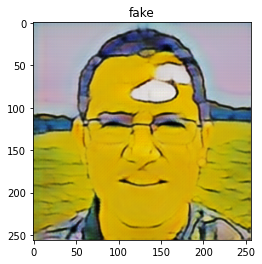

./results/person2simpson/test_latest/images/real_face_9365_real.png


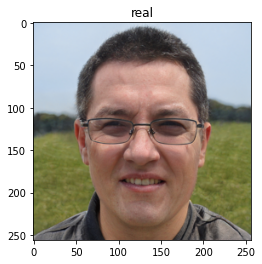

End of epoch 1 / 15 	 Time Taken: 2720 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 2, iters: 24, time: 0.492, data: 0.000) D_A: 0.151 G_A: 0.212 cycle_A: 1.862 idt_A: 0.280 D_B: 0.105 G_B: 0.325 cycle_B: 0.781 idt_B: 0.890 
saving the latest model (epoch 2, total_iters 10000)
(epoch: 2, iters: 124, time: 0.292, data: 0.000) D_A: 0.148 G_A: 0.823 cycle_A: 1.372 idt_A: 0.414 D_B: 0.040 G_B: 0.537 cycle_B: 1.059 idt_B: 0.499 
(epoch: 2, iters: 224, time: 0.291, data: 0.000) D_A: 0.152 G_A: 0.388 cycle_A: 1.132 idt_A: 0.301 D_B: 0.455 G_B: 0.295 cycle_B: 0.841 idt_B: 0.522 
(epoch: 2, iters: 324, time: 0.292, data: 0.000) D_A: 0.166 G_A: 0.799 cycle_A: 1.366 idt_A: 0.330 D_B: 0.137 G_B: 0.233 cycle_B: 0.936 idt_B: 0.466 
(epoch: 2, iters: 424, time: 0.387, data: 0.000) D_A: 0.157 G_A: 0.450 cycle_A: 1.115 idt_A: 0.429 D_B: 0.069 G_B: 0.604 cycle_B: 0.975 idt_B: 0.505 
(epoch: 2, iters: 524, time: 0.292, data: 0.000) D_A: 0.090 G_A: 0.560 cycle_A: 1.246 idt_A: 0.642 D_B: 0.097 G_B: 0.2

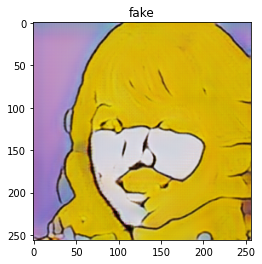

./results/person2simpson/test_latest/images/real_face_996_real.png


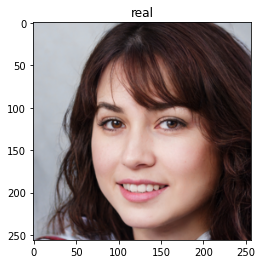

End of epoch 2 / 15 	 Time Taken: 2723 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 3, iters: 48, time: 0.524, data: 0.000) D_A: 0.215 G_A: 0.192 cycle_A: 1.636 idt_A: 0.377 D_B: 0.153 G_B: 0.398 cycle_B: 0.925 idt_B: 0.663 
saving the latest model (epoch 3, total_iters 20000)
(epoch: 3, iters: 148, time: 0.292, data: 0.000) D_A: 0.111 G_A: 0.514 cycle_A: 1.477 idt_A: 0.255 D_B: 0.168 G_B: 0.373 cycle_B: 0.633 idt_B: 0.376 
(epoch: 3, iters: 248, time: 0.292, data: 0.000) D_A: 0.082 G_A: 0.605 cycle_A: 1.488 idt_A: 0.265 D_B: 0.132 G_B: 0.283 cycle_B: 0.725 idt_B: 0.521 
(epoch: 3, iters: 348, time: 0.292, data: 0.000) D_A: 0.102 G_A: 0.579 cycle_A: 0.918 idt_A: 0.354 D_B: 0.220 G_B: 0.315 cycle_B: 1.143 idt_B: 0.309 
(epoch: 3, iters: 448, time: 0.416, data: 0.000) D_A: 0.155 G_A: 0.451 cycle_A: 1.057 idt_A: 0.456 D_B: 0.219 G_B: 0.394 cycle_B: 1.137 idt_B: 0.423 
(epoch: 3, iters: 548, time: 0.291, data: 0.000) D_A: 0.094 G_A: 0.920 cycle_A: 1.015 idt_A: 0.309 D_B: 0.309 G_B: 0.1

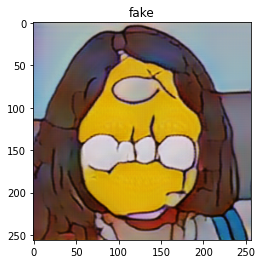

./results/person2simpson/test_latest/images/real_face_9358_real.png


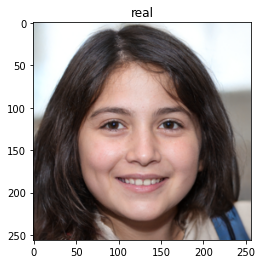

End of epoch 3 / 15 	 Time Taken: 2725 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 4, iters: 72, time: 0.538, data: 0.000) D_A: 0.123 G_A: 0.577 cycle_A: 1.048 idt_A: 0.280 D_B: 0.122 G_B: 0.389 cycle_B: 0.714 idt_B: 0.533 
saving the latest model (epoch 4, total_iters 30000)
(epoch: 4, iters: 172, time: 0.292, data: 0.000) D_A: 0.071 G_A: 0.491 cycle_A: 1.118 idt_A: 0.280 D_B: 0.093 G_B: 0.560 cycle_B: 0.645 idt_B: 0.401 
(epoch: 4, iters: 272, time: 0.292, data: 0.000) D_A: 0.082 G_A: 0.860 cycle_A: 1.219 idt_A: 0.296 D_B: 0.230 G_B: 0.331 cycle_B: 0.706 idt_B: 0.348 
(epoch: 4, iters: 372, time: 0.292, data: 0.000) D_A: 0.139 G_A: 0.342 cycle_A: 0.835 idt_A: 0.329 D_B: 0.273 G_B: 0.285 cycle_B: 0.819 idt_B: 0.244 
(epoch: 4, iters: 472, time: 0.415, data: 0.000) D_A: 0.105 G_A: 0.336 cycle_A: 0.911 idt_A: 0.352 D_B: 0.293 G_B: 0.298 cycle_B: 0.738 idt_B: 0.393 
(epoch: 4, iters: 572, time: 0.292, data: 0.000) D_A: 0.179 G_A: 0.397 cycle_A: 1.083 idt_A: 0.241 D_B: 0.234 G_B: 0.2

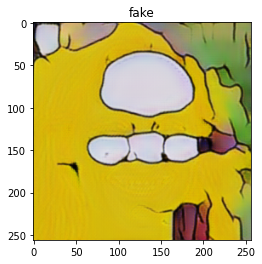

./results/person2simpson/test_latest/images/real_face_7966_real.png


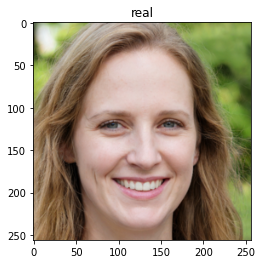

End of epoch 4 / 15 	 Time Taken: 2725 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 5, iters: 96, time: 0.516, data: 0.000) D_A: 0.083 G_A: 0.410 cycle_A: 1.439 idt_A: 0.339 D_B: 0.346 G_B: 0.348 cycle_B: 1.077 idt_B: 0.605 
saving the latest model (epoch 5, total_iters 40000)
(epoch: 5, iters: 196, time: 0.292, data: 0.000) D_A: 0.150 G_A: 0.407 cycle_A: 1.046 idt_A: 0.357 D_B: 0.312 G_B: 0.190 cycle_B: 0.786 idt_B: 0.383 
(epoch: 5, iters: 296, time: 0.292, data: 0.000) D_A: 0.200 G_A: 0.651 cycle_A: 1.316 idt_A: 0.292 D_B: 0.256 G_B: 0.209 cycle_B: 0.843 idt_B: 0.485 
(epoch: 5, iters: 396, time: 0.292, data: 0.000) D_A: 0.064 G_A: 0.782 cycle_A: 0.827 idt_A: 0.341 D_B: 0.292 G_B: 0.217 cycle_B: 0.916 idt_B: 0.297 
(epoch: 5, iters: 496, time: 0.407, data: 0.000) D_A: 0.096 G_A: 0.509 cycle_A: 0.847 idt_A: 0.310 D_B: 0.223 G_B: 0.210 cycle_B: 0.828 idt_B: 0.253 
(epoch: 5, iters: 596, time: 0.292, data: 0.000) D_A: 0.136 G_A: 0.356 cycle_A: 1.405 idt_A: 0.282 D_B: 0.293 G_B: 0.1

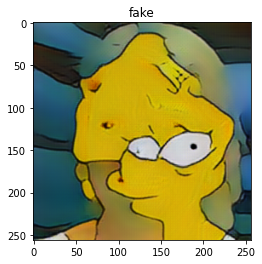

./results/person2simpson/test_latest/images/real_face_7151_real.png


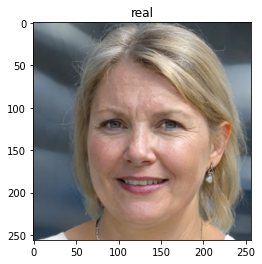

End of epoch 5 / 15 	 Time Taken: 2727 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 6, iters: 20, time: 0.292, data: 0.000) D_A: 0.103 G_A: 0.504 cycle_A: 0.888 idt_A: 0.181 D_B: 0.217 G_B: 0.286 cycle_B: 0.581 idt_B: 0.412 
(epoch: 6, iters: 120, time: 0.538, data: 0.000) D_A: 0.084 G_A: 1.068 cycle_A: 1.328 idt_A: 0.258 D_B: 0.140 G_B: 0.809 cycle_B: 1.019 idt_B: 0.507 
saving the latest model (epoch 6, total_iters 50000)
(epoch: 6, iters: 220, time: 0.292, data: 0.000) D_A: 0.070 G_A: 0.757 cycle_A: 1.095 idt_A: 0.231 D_B: 0.146 G_B: 0.637 cycle_B: 0.842 idt_B: 0.460 
(epoch: 6, iters: 320, time: 0.292, data: 0.000) D_A: 0.083 G_A: 0.475 cycle_A: 1.354 idt_A: 0.231 D_B: 0.093 G_B: 0.462 cycle_B: 0.818 idt_B: 0.535 
(epoch: 6, iters: 420, time: 0.292, data: 0.000) D_A: 0.172 G_A: 0.220 cycle_A: 1.261 idt_A: 0.247 D_B: 0.092 G_B: 0.722 cycle_B: 0.723 idt_B: 0.430 
(epoch: 6, iters: 520, time: 0.409, data: 0.000) D_A: 0.058 G_A: 0.439 cycle_A: 1.259 idt_A: 0.175 D_B: 0.229 G_B: 0.5

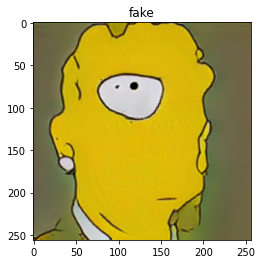

./results/person2simpson/test_latest/images/real_face_9124_real.png


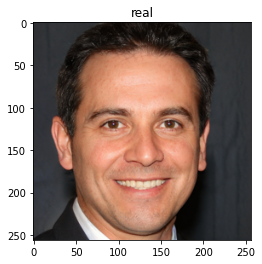

End of epoch 6 / 15 	 Time Taken: 2729 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 7, iters: 44, time: 0.291, data: 0.000) D_A: 0.075 G_A: 0.404 cycle_A: 1.580 idt_A: 0.237 D_B: 0.159 G_B: 0.403 cycle_B: 0.736 idt_B: 0.643 
(epoch: 7, iters: 144, time: 0.546, data: 0.000) D_A: 0.115 G_A: 0.927 cycle_A: 0.856 idt_A: 0.235 D_B: 0.090 G_B: 0.564 cycle_B: 0.658 idt_B: 0.305 
saving the latest model (epoch 7, total_iters 60000)
(epoch: 7, iters: 244, time: 0.292, data: 0.000) D_A: 0.176 G_A: 0.412 cycle_A: 0.829 idt_A: 0.249 D_B: 0.155 G_B: 0.309 cycle_B: 0.810 idt_B: 0.324 
(epoch: 7, iters: 344, time: 0.292, data: 0.000) D_A: 0.123 G_A: 0.421 cycle_A: 0.806 idt_A: 0.709 D_B: 0.056 G_B: 0.753 cycle_B: 1.292 idt_B: 0.356 
(epoch: 7, iters: 444, time: 0.292, data: 0.000) D_A: 0.031 G_A: 0.668 cycle_A: 1.046 idt_A: 0.160 D_B: 0.127 G_B: 0.310 cycle_B: 0.456 idt_B: 0.327 
(epoch: 7, iters: 544, time: 0.415, data: 0.000) D_A: 0.085 G_A: 0.354 cycle_A: 1.041 idt_A: 0.261 D_B: 0.230 G_B: 0.6

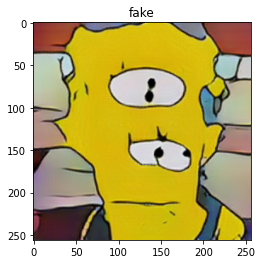

./results/person2simpson/test_latest/images/real_face_7516_real.png


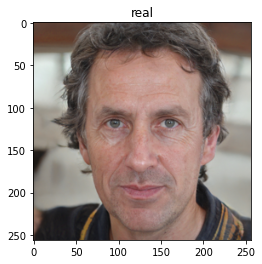

End of epoch 7 / 15 	 Time Taken: 2730 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 8, iters: 68, time: 0.292, data: 0.000) D_A: 0.059 G_A: 0.852 cycle_A: 0.858 idt_A: 0.215 D_B: 0.222 G_B: 0.125 cycle_B: 0.643 idt_B: 0.251 
(epoch: 8, iters: 168, time: 0.563, data: 0.000) D_A: 0.126 G_A: 0.640 cycle_A: 1.042 idt_A: 0.244 D_B: 0.098 G_B: 0.648 cycle_B: 0.690 idt_B: 0.365 
saving the latest model (epoch 8, total_iters 70000)
(epoch: 8, iters: 268, time: 0.292, data: 0.000) D_A: 0.105 G_A: 0.222 cycle_A: 0.738 idt_A: 0.415 D_B: 0.164 G_B: 0.489 cycle_B: 0.909 idt_B: 0.308 
(epoch: 8, iters: 368, time: 0.292, data: 0.000) D_A: 0.067 G_A: 0.516 cycle_A: 0.972 idt_A: 0.169 D_B: 0.106 G_B: 0.573 cycle_B: 0.504 idt_B: 0.327 
(epoch: 8, iters: 468, time: 0.291, data: 0.000) D_A: 0.108 G_A: 0.645 cycle_A: 0.768 idt_A: 0.222 D_B: 0.140 G_B: 0.632 cycle_B: 0.785 idt_B: 0.270 
(epoch: 8, iters: 568, time: 0.414, data: 0.000) D_A: 0.058 G_A: 0.519 cycle_A: 0.878 idt_A: 0.194 D_B: 0.204 G_B: 0.8

In [ ]:
# adapted from: https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/test.py

for epoch in range(opt.epoch_count, opt.n_epochs + opt.n_epochs_decay + 1):    # outer loop for different epochs; we save the model by <epoch_count>, <epoch_count>+<save_latest_freq>
    epoch_start_time = time.time()  # timer for entire epoch
    iter_data_time = time.time()    # timer for data loading per iteration
    epoch_iter = 0                  # the number of training iterations in current epoch, reset to 0 every epoch
    visualizer.reset()              # reset the visualizer: make sure it saves the results to HTML at least once every epoch
    model.update_learning_rate()    # update learning rates in the beginning of every epoch.
    
    for i, data in enumerate(dataset):  # inner loop within one epoch
        iter_start_time = time.time()  # timer for computation per iteration

        if total_iters % opt.print_freq == 0:
            t_data = iter_start_time - iter_data_time

        total_iters += opt.batch_size
        epoch_iter += opt.batch_size
        model.set_input(data)         # unpack data from dataset and apply preprocessing
        model.optimize_parameters()   # calculate loss functions, get gradients, update network weights

        if total_iters % opt.display_freq == 0:   # display images on visdom and save images to a HTML file
            save_result = total_iters % opt.update_html_freq == 0
            model.compute_visuals()
            visualizer.display_current_results(model.get_current_visuals(), epoch, save_result)

        if total_iters % opt.print_freq == 0:    # print training losses and save logging information to the disk
            losses = model.get_current_losses()
            t_comp = (time.time() - iter_start_time) / opt.batch_size
            visualizer.print_current_losses(epoch, epoch_iter, losses, t_comp, t_data)
            if opt.display_id > 0:
                visualizer.plot_current_losses(epoch, float(epoch_iter) / dataset_size, losses)

        if total_iters % opt.save_latest_freq == 0:   # cache our latest model every <save_latest_freq> iterations
            print('saving the latest model (epoch %d, total_iters %d)' % (epoch, total_iters))
            save_suffix = 'iter_%d' % total_iters if opt.save_by_iter else 'latest'
            model.save_networks(save_suffix)

        iter_data_time = time.time()


    if epoch % opt.save_epoch_freq == 0:              # cache our model every <save_epoch_freq> epochs
        print('saving the model at the end of epoch %d, iters %d' % (epoch, total_iters))
        model.save_networks('latest')
        model.save_networks(epoch)
        copy_to_drive()
       # test_model(1, 'AtoB',None)
        test_model(1, 'BtoA')

    print('End of epoch %d / %d \t Time Taken: %d sec' % (epoch, opt.n_epochs + opt.n_epochs_decay, time.time() - epoch_start_time))